# **Build Recommend System**

## *Install & Import libraries*

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import requests
import json
import tensorflow as tf
import keras
from pprint import pprint

## *Loading data by API*

### *Review data*

In [2]:
n_reviews = 100000
review_url = "http://42.117.27.86:8080/api/reviews?limit={}&page=1".format(n_reviews)
# Lây
request = requests.get(review_url)

In [2]:
import pandas as pd

raw_review_data = pd.read_csv("./data/reviews.csv").iloc[:100000].to_dict("records")

In [3]:
def parser_infor_review(json):
  d = dict()
  d['user_id'] = json.get('user_id_review')
  d['movie_id'] = json.get('movie_id')
  d['rating'] = json.get('ratings')
  d['agree'] = json.get('total_agree')

  return d

In [4]:
review_data = []
for infor in raw_review_data:
    review_data.append(parser_infor_review(infor))

In [5]:
df = pd.DataFrame(review_data)
df = df[~df['rating'].isna()]

In [6]:
df['rating'] = df['rating'].apply(pd.to_numeric, errors='coerce')
df

,user_id,movie_id,rating,agree
1,ur2467618,tt0004972,3.0,98 out of 159
2,ur1888886,tt0004972,10.0,192 out of 321
3,ur15148330,tt0004972,8.0,38 out of 60
7,ur2670273,tt0004972,1.0,216 out of 401
8,ur16588387,tt0004972,1.0,173 out of 300
...,...,...,...,...
99994,ur13022713,tt0062622,10.0,4 out of 8
99996,ur45150762,tt0062622,4.0,3 out of 7
99997,ur90750895,tt0062622,1.0,7 out of 21
99998,ur0128216,tt0062622,9.0,4 out of 10


In [7]:
df = df[df['rating'] != {'$numberDouble': 'NaN'}]
df

,user_id,movie_id,rating,agree
1,ur2467618,tt0004972,3.0,98 out of 159
2,ur1888886,tt0004972,10.0,192 out of 321
3,ur15148330,tt0004972,8.0,38 out of 60
7,ur2670273,tt0004972,1.0,216 out of 401
8,ur16588387,tt0004972,1.0,173 out of 300
...,...,...,...,...
99994,ur13022713,tt0062622,10.0,4 out of 8
99996,ur45150762,tt0062622,4.0,3 out of 7
99997,ur90750895,tt0062622,1.0,7 out of 21
99998,ur0128216,tt0062622,9.0,4 out of 10


### *Movie data*

In [8]:
n_movies = 50000
movie_url = "http://42.117.27.86:8080/api/movies?limit={}&page=1".format(n_movies)
request = requests.get(movie_url)

ConnectionError: HTTPConnectionPool(host='42.117.27.86', port=8080): Max retries exceeded with url: /api/movies?limit=50000&page=1 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002DE0466B580>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

In [10]:
raw_movie_data = pd.read_csv("./data/movies.csv").iloc[:50000].to_dict("records")

In [11]:
def parser_infor_movie(json):
  d = dict()
  d['movie_id'] = json.get('id')
  d['movie_title'] = json.get('title')

  return d

In [12]:
movie_data = []
for infor in raw_movie_data:
    movie_data.append(parser_infor_movie(infor))

In [13]:
df_2 = pd.DataFrame(movie_data)
df_2

,movie_id,movie_title
0,tt0000012,L&apos;arrivée d&apos;un train à La Ciotat
1,tt0000417,Le voyage dans la lune
2,tt0000439,The Great Train Robbery
3,tt0000546,Dream of a Rarebit Fiend
4,tt0000628,Adventures of Dollie
...,...,...
32149,tt9906260,Hero
32150,tt9907782,Eight for Silver
32151,tt9908860,Blown Away
32152,tt9914644,9/11: Escape from the Towers


## *Forming suitable dataset for Deep Learning model*

In [14]:
merged_dataset = pd.merge(df, df_2, how='inner', on='movie_id')
merged_dataset.head()

,user_id,movie_id,rating,agree,movie_title
0,ur2467618,tt0004972,3.0,98 out of 159,The Birth of a Nation
1,ur1888886,tt0004972,10.0,192 out of 321,The Birth of a Nation
2,ur15148330,tt0004972,8.0,38 out of 60,The Birth of a Nation
3,ur2670273,tt0004972,1.0,216 out of 401,The Birth of a Nation
4,ur16588387,tt0004972,1.0,173 out of 300,The Birth of a Nation


In [15]:
merged_dataset['movie_title'].value_counts()

movie_title
12 Angry Men                       1984
Citizen Kane                       1407
Psycho                             1359
Casablanca                         1313
Il buono, il brutto, il cattivo    1230
                                   ... 
Suvorov                               3
The Man Who Never Was                 3
Behind the Front                      2
Putkinotko                            1
In the Days of Daniel Boone           1
Name: count, Length: 426, dtype: int64

In [16]:
refined_dataset = merged_dataset.groupby(by=['user_id','movie_title'], as_index=False).agg({"rating":"mean"})
refined_dataset.head()

,user_id,movie_title,rating
0,ur0000169,What Ever Happened to Baby Jane?,8.0
1,ur0000578,Portrait of Jennie,10.0
2,ur0001027,Doctor Zhivago,10.0
3,ur0001107,Auntie Mame,5.0
4,ur0001107,The Great Dictator,1.0


### *Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks*

In [17]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user_id'].values)
n_users = refined_dataset['user'].nunique()

In [18]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie_title'].values)
n_movies = refined_dataset['movie'].nunique()

In [19]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(29758, 426, 1.0, 10.0)

In [20]:
refined_dataset.head()

,user_id,movie_title,rating,user,movie
0,ur0000169,What Ever Happened to Baby Jane?,8.0,0,409
1,ur0000578,Portrait of Jennie,10.0,1,228
2,ur0001027,Doctor Zhivago,10.0,2,69
3,ur0001107,Auntie Mame,5.0,3,23
4,ur0001107,The Great Dictator,1.0,3,320


## *Training & Testing*

### *Splitting the data into training and testing*

In [21]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70823, 2), (7870, 2), (70823,), (7870,))

In [22]:
n_factors = 150

In [23]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [24]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

### *Building a Softmax Deep Neural Network*

In [25]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/70


554/554 [==============================] - 3s 5ms/step - loss: 1.1809 - accuracy: 0.0261 - val_loss: 0.6959 - val_accuracy: 0.0262 - lr: 0.0100
Epoch 2/70
554/554 [==============================] - 3s 5ms/step - loss: 0.6781 - accuracy: 0.0261 - val_loss: 0.6471 - val_accuracy: 0.0262 - lr: 0.0100
Epoch 3/70
554/554 [==============================] - 3s 5ms/step - loss: 0.6566 - accuracy: 0.0261 - val_loss: 0.6389 - val_accuracy: 0.0262 - lr: 0.0100
Epoch 4/70
554/554 [==============================] - 3s 5ms/step - loss: 0.6516 - accuracy: 0.0261 - val_loss: 0.6362 - val_accuracy: 0.0262 - lr: 0.0100
Epoch 5/70
554/554 [==============================] - 3s 5ms/step - loss: 0.6488 - accuracy: 0.0261 - val_loss: 0.6349 - val_accuracy: 0.0262 - lr: 0.0100
Epoch 6/70
554/554 [==============================] - 3s 5ms/step - loss: 0.6472 - accuracy: 0.0261 - val_loss: 0.6345 - val_accuracy: 0.0262 - lr: 0.0100
Epoch 7/70
554/554 [==============================] - 3s 5ms/step - 

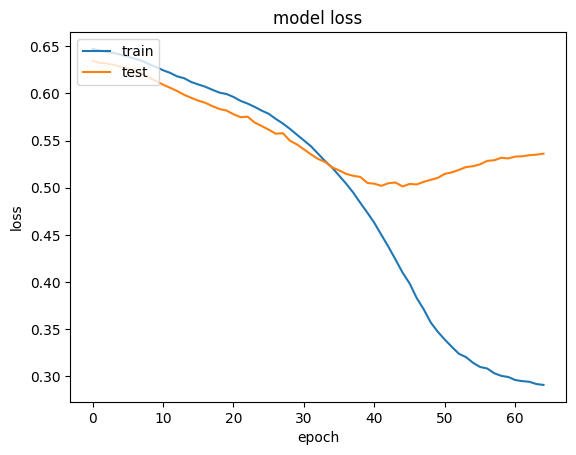

In [27]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [28]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user_id'] == user_id]['movie_title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user_id'] == user_id]['movie'])
  print(len(seen_movies))
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  print(len(unseen_movies))
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

  # Tạo DataFrame từ danh sách tên phim và dự đoán ratings
  recommendations_df = pd.DataFrame({
      'Tên Phim': recommended_movies[:n_movies],
      'Rating Dự Đoán': predicted_ratings[sorted_index][:n_movies]*(max_rating - min_rating)  + min_rating# Lấy các dự đoán tương ứng
  })

  return recommendations_df

In [31]:
# Test
df[df['user_id'] == "ur2467618"]['movie_id'].value_counts()

movie_id
tt0004972    1
tt0052225    1
tt0053114    1
tt0053072    1
tt0052997    1
            ..
tt0039661    1
tt0039628    1
tt0039501    1
tt0039286    1
tt0062512    1
Name: count, Length: 497, dtype: int64

In [29]:
print("Enter user id")
user_id= input()

print("Enter number of movies to be recommended:")
n_movies = int(input())
rating_df = recommender_system(user_id,model,n_movies)
rating_df

Enter user id


## *Save model and load model to use*

In [30]:
model.save('Recommend_System')

INFO:tensorflow:Assets written to: Recommend_System\assets


INFO:tensorflow:Assets written to: Recommend_System\assets


In [34]:
loaded_model = tf.keras.models.load_model('./data/Recommend_System')

In [32]:
print("Enter user id")
rating_df = recommender_system("ur2467618",loaded_model, 2)
rating_df

Enter user id


NameError: name 'loaded_model' is not defined